<a href="https://colab.research.google.com/github/msilver22/data_augmentation/blob/main/fashionMNIST/fashionMNIST_wgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 40.0 MB/s eta 0:00:00


In [ ]:
!pip install lightning --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 46.6 MB/s eta 0:00:00


In [ ]:
import os
import lightning as L
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import matplotlib.pyplot as plt
import scipy
import torch.optim as optim

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
print(f'Trainset size: {len(trainset)}')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9250050.62it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 156561.87it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 567550.16it/s] 


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23469866.30it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Trainset size: 60000


SHAPE: torch.Size([1, 28, 28])
MIN: tensor(-1.) MAX: tensor(1.)


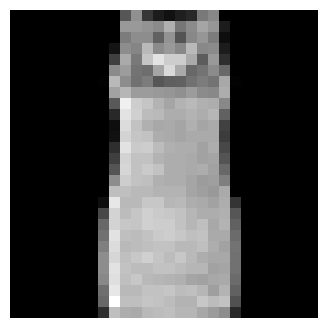

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]
print("SHAPE:", image.shape)
print("MIN:", torch.min(images), "MAX:", torch.max(images))

plt.figure(figsize=(4, 4))
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
BATCH_SIZE = 64
NUM_WORKERS = int(os.cpu_count() / 2)
print(f'Number of workers: {NUM_WORKERS}')
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

Using device: cuda
Number of workers: 1


In [ ]:
class FashionMNISTDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])
        self.dims = (1, 28, 28)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            fmnist_full = datasets.FashionMNIST(self.data_dir, train=True, download = True, transform=self.transform)
            self.fmnist_train, self.fmnist_val = random_split(fmnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.fmnist_test = datasets.FashionMNIST(self.data_dir, train=False, download = True, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.fmnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(self.fmnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.fmnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_features=100, out_features=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, out_features),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.model(z)
        z = z.view(z.size(0), -1)
        return z

In [ ]:
x = torch.randn(1, 100)
generator = Generator()
output = generator(x)
print(output.shape)

torch.Size([1, 784])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_features=784, out_features=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,out_features)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
x = torch.randn(1, 1, 28, 28)
discriminator = Discriminator()
output = discriminator(x)
print(output.shape)

torch.Size([1, 1])


In [ ]:
class WGAN(L.LightningModule):
    def __init__(
        self,
        latent_dim: int = 100,
        lr: float = 0.00005,
        batch_size: int = BATCH_SIZE,
        n_critic = 5,
        clip_value = 0.01,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.clip_value = clip_value

        # networks
        self.generator = Generator().to(device)
        self.discriminator = Discriminator().to(device)

        # loss
        self.training_step_outputs_wasserstein = []
        self.w_distance = []

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch):
        imgs, _ = batch
        imgs = imgs.to(device)

        optimizer_g, optimizer_d = self.optimizers()

        ## ----------------------------------------------------------------
        ## Train discriminator to compute Wasserstein distance
        ## ----------------------------------------------------------------

        for _ in range(self.n_critic):
            # Sample random noise vectors
            z = np.random.uniform(-1, 1, size=(self.batch_size, self.latent_dim))
            z = torch.from_numpy(z).float().to(device)
            # Generate fake images
            fake_images = self(z)
            # Compute Wasserstein distance
            real_logits = self.discriminator(imgs)
            fake_logits = self.discriminator(fake_images)
            d_loss = -torch.mean(real_logits) + torch.mean(fake_logits)

            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            #Making the discriminator K-Lipschitz
            for p in self.discriminator.parameters():
                p.data.clamp_(-self.clip_value, self.clip_value)

        self.log('wasserstein_d', -d_loss, on_step=True, prog_bar=True, logger=True)
        self.training_step_outputs_wasserstein.append(-d_loss)

        ## ----------------------------------------------------------------
        ## Train generator to minimize the Wasserstein distance
        ## ----------------------------------------------------------------

        # Sample random noise vectors
        z = np.random.uniform(-1, 1, size=(self.batch_size, self.latent_dim))
        z = torch.from_numpy(z).float().to(device)
        # Generate fake images
        fake_images = self(z)
        # Compute Wasserstein distance
        fake_logits = self.discriminator(fake_images)
        g_loss = -torch.mean(fake_logits)
        #self.log("loss_G", g_loss, prog_bar=True)
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    def on_train_epoch_end(self):
        w_distance_epoch = torch.stack(self.training_step_outputs_wasserstein).mean()
        self.w_distance.append(w_distance_epoch.item())
        self.training_step_outputs_wasserstein.clear()  # free memory

        # Save generator weights at specific epochs
        save_epochs = [1, 5, 10, 20, 40, 60, 80, 100, 200]
        if self.current_epoch + 1 in save_epochs:
           torch.save(self.generator.state_dict(), f'generator_epoch_{self.current_epoch + 1}.pth')

    def configure_optimizers(self):
        lr = self.lr
        opt_g = optim.RMSprop(self.generator.parameters(), lr=lr)
        opt_d = optim.RMSprop(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 1.5 M  | train
1 | discriminator | Discriminator | 1.5 M  | train
--------------------------------------------------------
2.9 M     Trainable params
0        

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


[LOG] Generator weights saved.


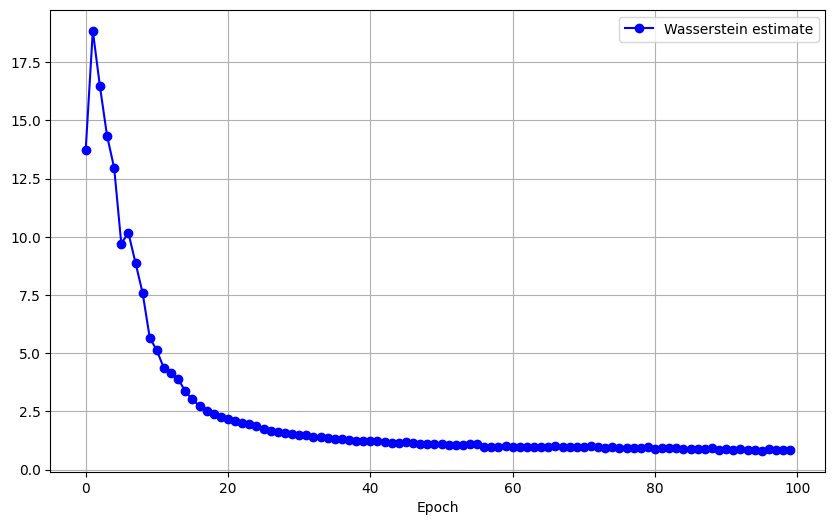

In [ ]:
def main():
    dm = FashionMNISTDataModule()
    model = WGAN()
    trainer = L.Trainer(
        max_epochs=100,
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,
        enable_progress_bar=True
    )
    trainer.fit(model, dm)
    torch.save(model.generator.state_dict(), 'generator_weights_final.pth')
    print("[LOG] Generator weights saved.")
    w_distances = model.w_distance
    plot_epochs = range(0, len(w_distances))

    plt.figure(figsize=(10, 6))
    plt.plot(plot_epochs, w_distances, "-o", label="Wasserstein estimate", color="blue")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()

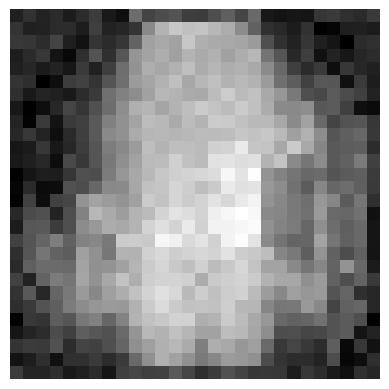

In [ ]:
latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_1.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
fake_image = fake_image.view(1, 1, 28, 28).detach()
plt.imshow(fake_image[0].numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

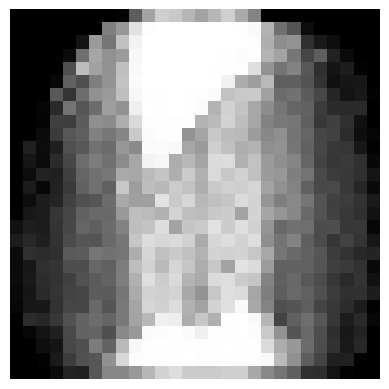

In [ ]:
latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_5.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
fake_image = fake_image.view(1, 1, 28, 28).detach()
plt.imshow(fake_image[0].numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

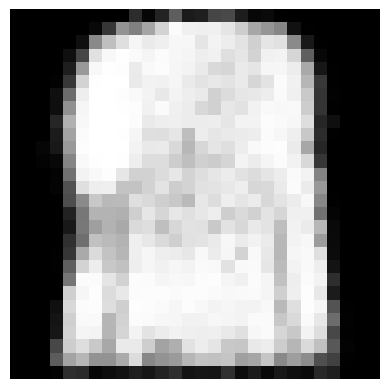

In [ ]:
latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_10.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
fake_image = fake_image.view(1, 1, 28, 28).detach()
plt.imshow(fake_image[0].numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

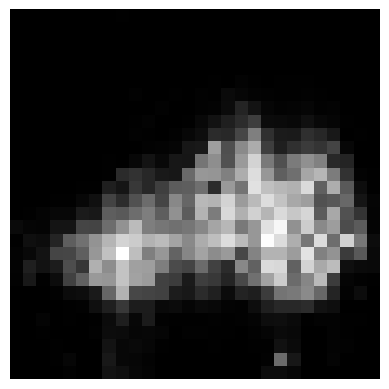

In [ ]:
latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_20.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
fake_image = fake_image.view(1, 1, 28, 28).detach()
plt.imshow(fake_image[0].numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

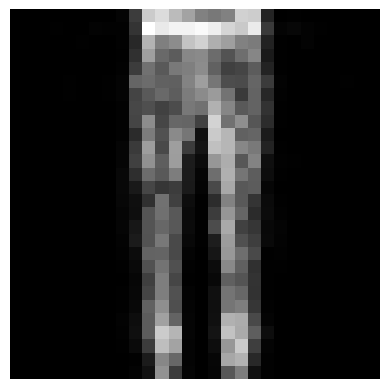

In [ ]:
latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_40.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
fake_image = fake_image.view(1, 1, 28, 28).detach()
plt.imshow(fake_image[0].numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

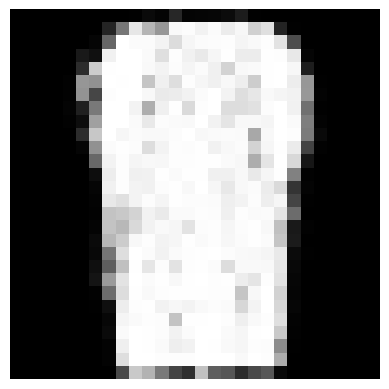

In [ ]:
latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_60.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
fake_image = fake_image.view(1, 1, 28, 28).detach()
plt.imshow(fake_image[0].numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.show()

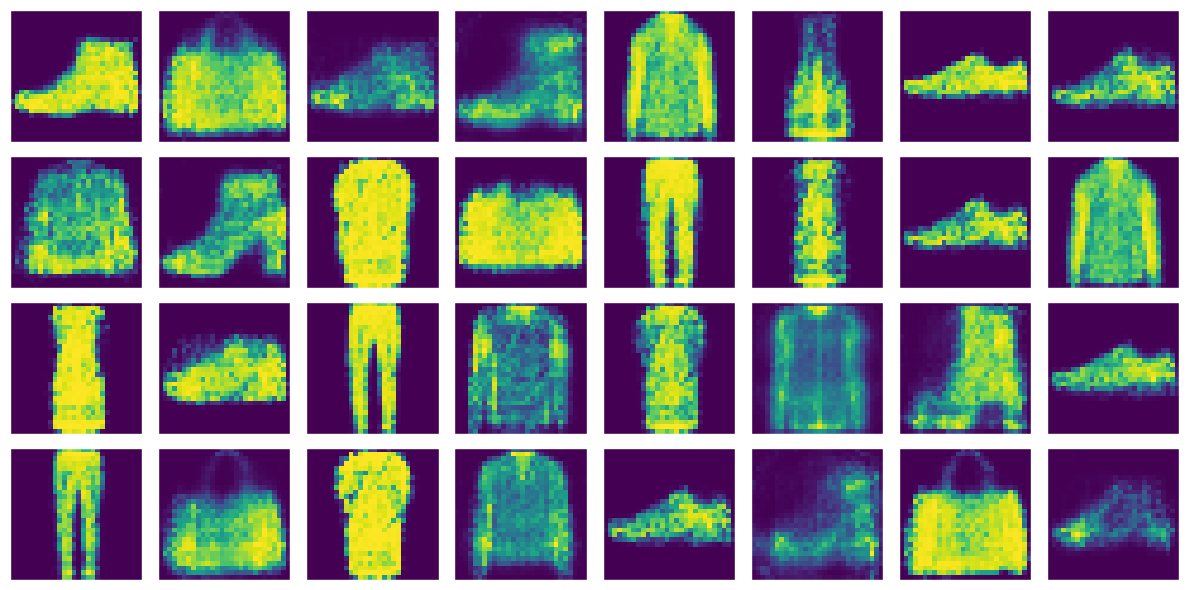

In [ ]:
import math

def display_images(images, n_cols=4, figsize=(12, 6)):

    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

latent_dim = 100
g = Generator(in_features=100, out_features=784)
g.load_state_dict(torch.load('generator_epoch_100.pth'))
g.eval()
z = np.random.uniform(-1, 1, size=(32, 100))
z = torch.from_numpy(z).float()
fake_images = g(z)
# Reshape and display
fake_images = fake_images.view(32, 1, 28, 28).detach()
display_images(fake_images, n_cols=8)

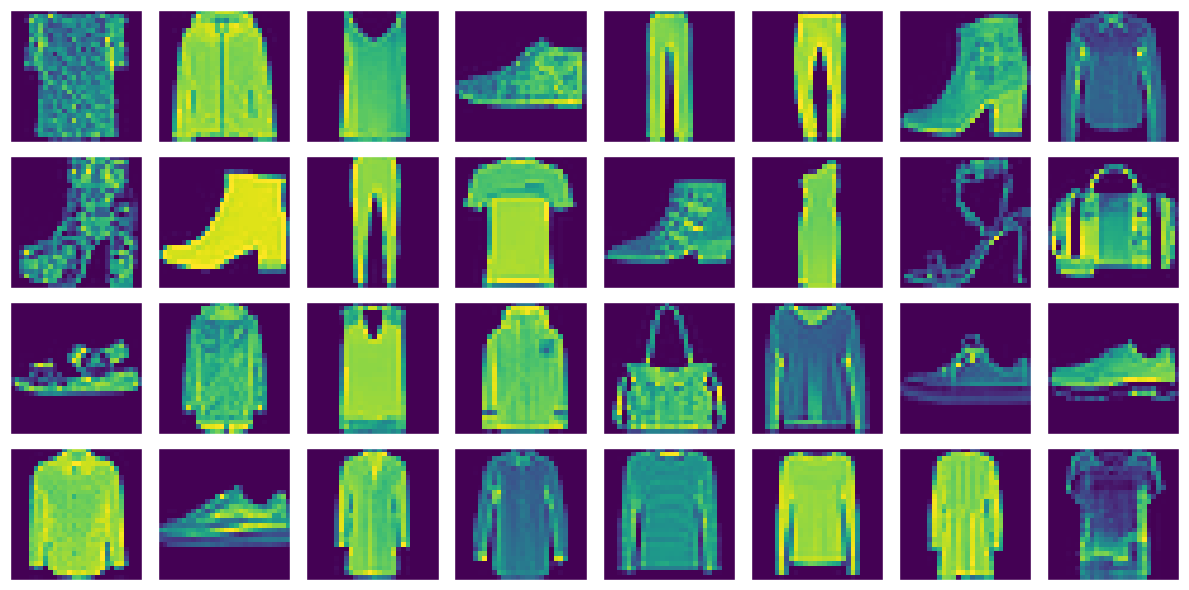

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
image_batch = next(iter(train_loader))
display_images(images=image_batch[0][:32], n_cols=8)
